## Test
asdasdf

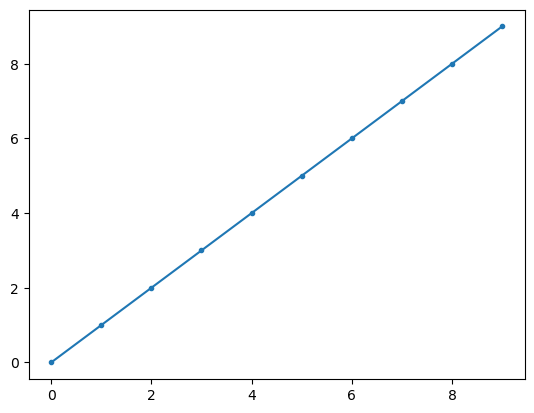

In [5]:
import numpy as np 
import matplotlib.pyplot as plt

def pippo():
    plt.plot(np.arange(10), '.-')
    
pippo()

In [6]:

!pip install git+https://github.com/ArcetriAdaptiveOptics/OAO24.git
from oao24 import package_data
dark_image = np.load(package_data.tuto3_folder() / "ID_110.npy")
open_loop_image = np.load(package_data.tuto3_folder() / "ID_105.npy")

  Cloning https://github.com/ArcetriAdaptiveOptics/OAO24.git to /private/var/folders/yy/y6mh4b390sj24kqkcp9nl2c40000gp/T/pip-req-build-s7nuc72z
  Running command git clone --filter=blob:none --quiet https://github.com/ArcetriAdaptiveOptics/OAO24.git /private/var/folders/yy/y6mh4b390sj24kqkcp9nl2c40000gp/T/pip-req-build-s7nuc72z
  Resolved https://github.com/ArcetriAdaptiveOptics/OAO24.git to commit 73d7ec4d497dbe08e9ead19c51cf2c1e9b56c76b
  Preparing metadata (setup.py) ... done


In [7]:
dark_image.shape

(512, 640)